# Tutorial 0: get the phenotype and fitness landscape 

If you didn't install dlim: !pip install dlim

dlim includes:
- DLIM: model 
- utils: for data and training 
- plot_figure: for plotting figures
- sim_data: simulate data points 


In [1]:
# Standard imports 
from numpy import mean, linspace
from numpy.random import choice
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Load dlim model and data 
from dlim import DLIM
from dlim.utils import Data_model, train

### Load your data

You can change the file to your own path, if your number of genes is N, i.e., nb_gene = N:
- The first N columns will be the mutation on each gene
- The last column will be the fitness value 
- You should not include the head and index for your own csv file 

Data_model function will change the data in your file to tensor data format, data.data:
- The first N columns will be the token for the mutations on each gene
- The last column will be the fitness value 


In [2]:
# here you can change to your file's path 
file_name = "data/data_env_2.csv"
# number of genes in your file 
nb_gene = 2 
data = Data_model(file_name, nb_gene)
data.data

tensor([[ 2.2000e+01,  2.2000e+01, -1.3284e-01],
        [ 2.2000e+01,  1.6000e+01, -1.3614e-01],
        [ 2.2000e+01,  0.0000e+00, -1.3286e-01],
        ...,
        [ 3.3000e+01,  3.5000e+01, -4.0176e-04],
        [ 3.3000e+01,  2.9000e+01,  4.5618e-03],
        [ 3.3000e+01,  6.0000e+00, -6.2161e-03]], dtype=torch.float64)

### Define a DLIM model


- nb_state: the number of possible mutations on each gene, 
    if for each gene, you have different number of possible mutations, then nb_state will be the maximum number of mutations 
- hid: the number of neurons in the hid layer
- nb_layer: the number of layer for the neural network 

In [3]:
model = DLIM(nb_gene, nb_state=37, hid=16, nb_layer=1)

The overall construction of this model is schematized in the following figure

![alt text](tutorial_figure/dlim.png "The architecture of DLIM")

The model tries to predict the phenotype value for each mutation on genes and fitness at the same time


### Split the data and train 

In [4]:
# choose 20% of data as validation dataset and the left as training dataset 
train_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.8))
train_data = data[train_id, :]
val_data = data[[i for i in range(data.data.shape[0]) if i not in train_data], :]

losses = train(model, train_data, lr=1e-2, nb_epoch=500, bsize=16, val_data=val_data, wei_dec=1e-2)

### Check the learning loss 

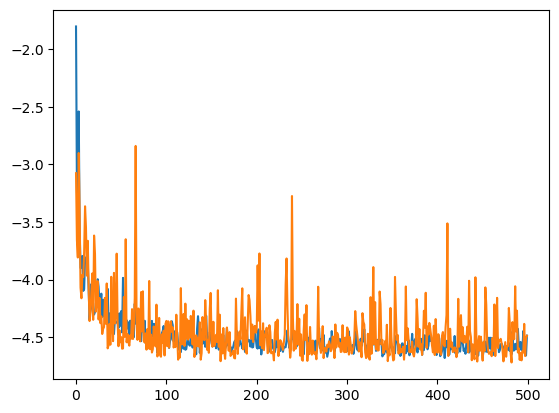

In [5]:
train_l, val_l = zip(*losses)
# plot the training and validation curve 
plt.plot(train_l)
plt.plot(val_l)
plt.show()

### Check the fitting quality 

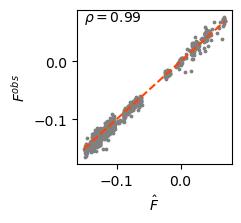

In [6]:
fit, var, _ = model(val_data[:, :-1].long(), detach=True)

fig, ax = plt.subplots(1,  figsize=(2, 2))
ax.scatter(fit, val_data[:, [-1]].detach(), s=3, c="grey")
x = linspace(min(fit), max(fit), num=100)
y = linspace(min(fit), max(fit), num=100)
ax.plot(x, y, lw=1.5, linestyle="--", c="orangered")
ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
score = pearsonr(fit.flatten(), val_data[:, [-1]].flatten())[0]
ax.text(fit.min(), fit.max(), f"$\\rho={score:.2f}$")
fig.show()

### Plot the landscape 

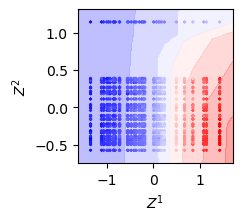

In [7]:
fig, bx = plt.subplots(1,  figsize=(2, 2))
model.plot(bx, data)

### Get the relationship between estimated phenotype and fitness

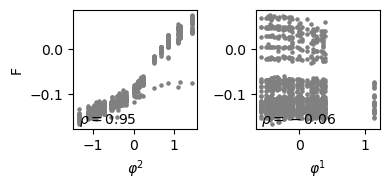

In [8]:
fig, (cx, dx) = plt.subplots(1, 2,  figsize=(4, 2))
fit_a, var_a, lat_a = model(data[:, :-1].long(), detach=True)
score_1 = pearsonr(lat_a[:, 0], data[:, -1])[0]
score_2 = pearsonr(lat_a[:, 1], data[:, -1])[0]
cx.scatter(lat_a[:, 0], data[:, -1], s=5, c="grey")
dx.scatter(lat_a[:, 1], data[:, -1], s=5, c="grey")
cx.text(lat_a[:, 0].min(),  data[:, -1].min(), f"$\\rho={score_1:.2f}$")
dx.text(lat_a[:, 1].min(),  data[:, -1].min(), f"$\\rho={score_2:.2f}$")
cx.set_ylabel("F")
dx.set_xlabel("$\\varphi^1$")
cx.set_xlabel("$\\varphi^2$")
plt.tight_layout()
plt.show()

### Get the variance of prediction 

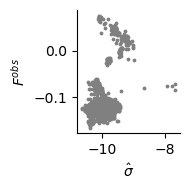

In [9]:
fig, ax = plt.subplots(1, figsize=(2, 2), sharey=True)
ax.scatter(var_a.log(), data[:, [-1]], s=3, c="grey")
ax.set_xlabel("$\\hat{\\sigma}$")
ax.set_ylabel("$F^{obs}$")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
plt.tight_layout()
plt.show()